In [33]:
import os

input_dir = "../content/stare-images/"
target_dir = "../content/labels-ah/"
img_size = (160, 160)
num_classes = 3
batch_size = 4

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".ppm")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".ppm") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 20
../content/stare-images/im0001.ppm | ../content/labels-ah/im0001.ah.ppm
../content/stare-images/im0002.ppm | ../content/labels-ah/im0002.ah.ppm
../content/stare-images/im0003.ppm | ../content/labels-ah/im0003.ah.ppm
../content/stare-images/im0004.ppm | ../content/labels-ah/im0004.ah.ppm
../content/stare-images/im0005.ppm | ../content/labels-ah/im0005.ah.ppm
../content/stare-images/im0044.ppm | ../content/labels-ah/im0044.ah.ppm
../content/stare-images/im0077.ppm | ../content/labels-ah/im0077.ah.ppm
../content/stare-images/im0081.ppm | ../content/labels-ah/im0081.ah.ppm
../content/stare-images/im0082.ppm | ../content/labels-ah/im0082.ah.ppm
../content/stare-images/im0139.ppm | ../content/labels-ah/im0139.ah.ppm


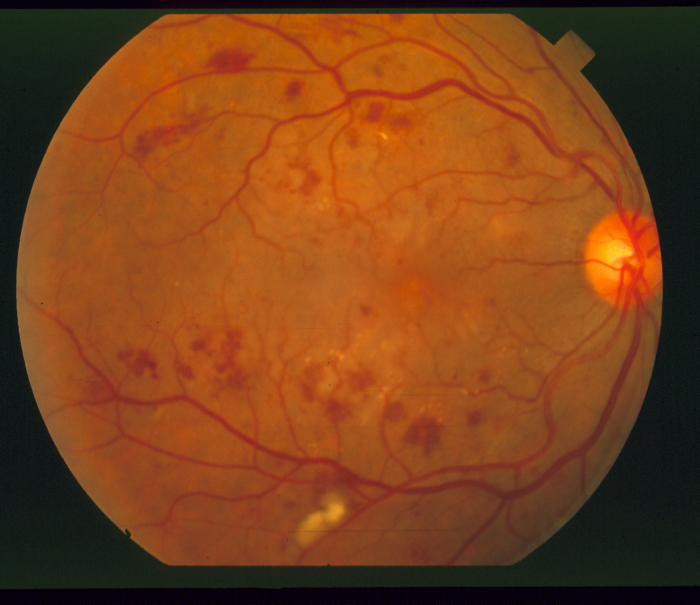

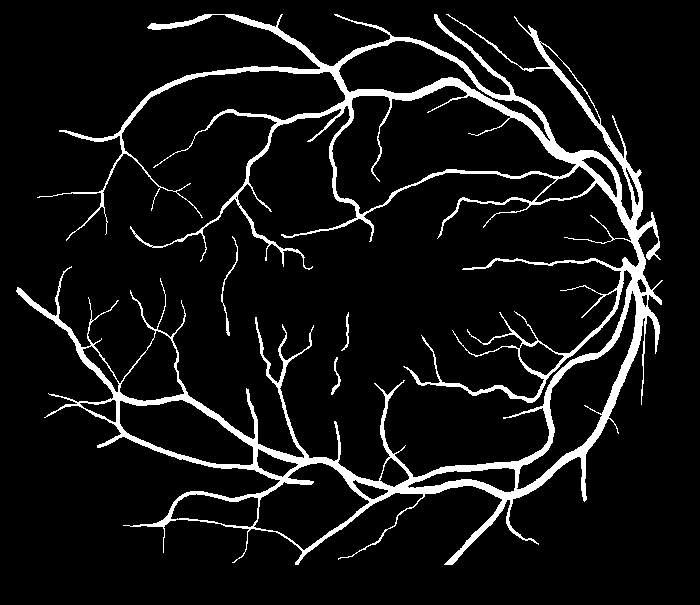

In [34]:
# from IPython.display import Image, display
from IPython.display import display
import PIL
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import load_img
from numpy import asarray


# Display input image #7
display(Image.open(input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

In [35]:
img = load_img(target_img_paths[0], target_size=img_size, color_mode="grayscale")
img = Image.fromarray(asarray(img)/255).convert('L')

In [36]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from skimage.transform import resize


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            
            img = Image.fromarray(asarray(img)/255).convert('L')

            y[j] = np.expand_dims(img, 2)
            # # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            # y[j] -= 1
        return x, y

In [37]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    # outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    outputs = layers.Conv2D(num_classes, 1, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [38]:
import random

# Split our img paths into a training and a validation set
val_samples = 4
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_target_img_paths, val_target_img_paths)

In [39]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
4/4 [==============================] - 10s 1s/step - loss: 3.9242 - val_loss: 55.2139
Epoch 2/15
4/4 [==============================] - 4s 1s/step - loss: 1.8077 - val_loss: 42.2283
Epoch 3/15
4/4 [==============================] - 4s 1s/step - loss: 1.0576 - val_loss: 4.9257
Epoch 4/15
4/4 [==============================] - 4s 971ms/step - loss: 1.0140 - val_loss: 9.3914
Epoch 5/15
4/4 [==============================] - 4s 976ms/step - loss: 0.5632 - val_loss: 9.3190
Epoch 6/15
4/4 [==============================] - 4s 1s/step - loss: 0.8121 - val_loss: 3.3207
Epoch 7/15
4/4 [==============================] - 4s 975ms/step - loss: 1.1163 - val_loss: 5.7408
Epoch 8/15
4/4 [==============================] - 4s 978ms/step - loss: 0.7696 - val_loss: 3.6641
Epoch 9/15
4/4 [==============================] - 4s 1s/step - loss: 0.3800 - val_loss: 2.0225
Epoch 10/15
4/4 [==============================] - 4s 1s/step - loss: 0.4233 - val_loss: 1.6705
Epoch 11/15
4/4 [=================

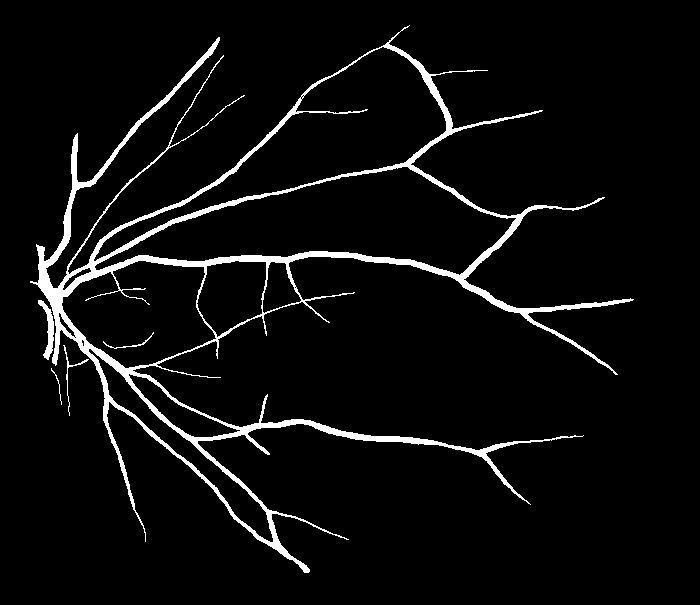

ValueError: ignored

In [85]:
import matplotlib.pyplot as plt
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #2
i = 2

# Display input image
# display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

# img = PIL.ImageOps.autocontrast(Image.fromarray(val_preds[i]))
# val_preds[0][50:60]
# pred = val_preds[i]
# cutoff = val_preds[i] > 0.9
# img = pred[cutoff]
# plt.imshow(img, cmap='gray')